<a href="https://colab.research.google.com/github/khanhtimn/Project-III/blob/main/refrag_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REFRAG v1: Training and Inference on Google Colab

This notebook provides a complete implementation of **REFRAG (REpresentation For RAG)** - a novel efficient decoding framework for Retrieval-Augmented Generation.

## Key Features
- **30.85x faster** Time-To-First-Token (TTFT) compared to standard RAG
- **16x larger context** with same memory budget
- **No perplexity loss** - maintains generation quality

## Training Pipeline
1. **Phase A (CPT-Recon)**: Reconstruction curriculum - trains encoder + projector
2. **Phase B (CPT-Next)**: Next-paragraph prediction - fine-tunes full model
3. **Policy Training**: REINFORCE-based selective expansion policy

## Requirements
- Google Colab with GPU runtime (T4/V100/A100)
- ~8GB+ GPU memory recommended

---

**Paper**: REFRAG: Rethinking RAG based Decoding (Meta Superintelligence Labs)

## 1. Environment Setup

First, let's check our GPU availability and set up the environment for training.

In [1]:
# Check GPU availability and CUDA version
import subprocess
import sys

def check_gpu():
    """Check if GPU is available and print details."""
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        print("GPU Information:")
        print(result.stdout)
        return True
    except FileNotFoundError:
        print("No NVIDIA GPU detected. Please enable GPU in Colab:")
        print("  Runtime -> Change runtime type -> Hardware accelerator -> GPU")
        return False

# Check GPU
has_gpu = check_gpu()

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("\n✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("\n✓ Running locally")

GPU Information:
Fri Feb  6 16:52:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   38C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------------------

In [2]:
%pip install -q transformers==4.43.3 accelerate sentencepiece sacrebleu "faiss-gpu-cu12[fix-cuda]"

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
	print(f"CUDA version: {torch.version.cuda}")
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.0/797.0 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN=userdata.get('HF_TOKEN')

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please save the token first.")

Successfully logged in to Hugging Face!


## 2. Import Libraries and Core Utilities

Import all necessary libraries and define core utility functions.

In [4]:
import os
import sys
import json
import math
import time
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from contextlib import nullcontext

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup,
)

try:
    import faiss
    FAISS_AVAILABLE = True
    print("✓ FAISS loaded successfully")
except ImportError:
    FAISS_AVAILABLE = False
    print("⚠ FAISS not available - will use CPU fallback")

# ----------------------------
# Utilities
# ----------------------------

def seed_everything(seed: int = 1337):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device():
    """Get the best available device (GPU/MPS/CPU)."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

DEVICE = get_device()
print(f"Using device: {DEVICE}")

# Set seeds
seed_everything()

✓ FAISS loaded successfully
Using device: cuda


## 3. Configuration

Define all hyperparameters and model configurations. Adjust these based on your GPU memory and training requirements.

In [5]:
@dataclass
class REFRAGConfig:
    """Configuration for REFRAG model and training."""

    # Model specifications
    encoder_name: str = "roberta-base"              # Encoder model for chunk embeddings
    decoder_name: str = "meta-llama/Llama-3.2-3B"   # Decoder LLM (Upgraded for A100)
    embed_model: str = "BAAI/bge-small-en-v1.5"    # Embedding model for retrieval

    # Compression parameters
    chunk_len_tokens: int = 32                      # k: tokens per chunk (compression ratio)
    max_q_tokens: int = 256                         # Max question tokens
    max_ctx_tokens: int = 1024                      # Max context tokens
    max_out_tokens: int = 128                       # Max output tokens
    selective_p: float = 0.25                       # Max expansion fraction

    # Training parameters
    policy_hidden: int = 256                        # Policy network hidden size
    lr: float = 2e-5                                # Learning rate
    cpt_next_lr: float = 5e-6                       # Lower LR for Phase B to prevent overfitting
    wd: float = 0.01                                # Weight decay (prevents overfitting)
    grad_clip: float = 1.0                          # Gradient clipping
    fp16: bool = True                               # Use mixed precision (AMP autocast on CUDA)
    seed: int = 1337

    # Training steps (reduce for quick testing)
    cpt_recon_steps: int = 900                      # CPT reconstruction steps
    cpt_next_steps: int = 400                       # CPT next-para steps (reduced to prevent overfitting)
    policy_steps: int = 900                         # Policy training steps

    # Retrieval
    topk: int = 4                                   # Top-k passages to retrieve

# Create default config
config = REFRAGConfig()

# Directories
DATA_DIR = "data"
RUNS_DIR = "runs"
INDEX_DIR = os.path.join(RUNS_DIR, "index")
CPT_RECON_DIR = os.path.join(RUNS_DIR, "cpt_recon")
CPT_NEXT_DIR = os.path.join(RUNS_DIR, "cpt_next")
POLICY_DIR = os.path.join(RUNS_DIR, "policy")

# Create directories
for d in [DATA_DIR, RUNS_DIR, INDEX_DIR, CPT_RECON_DIR, CPT_NEXT_DIR, POLICY_DIR]:
    os.makedirs(d, exist_ok=True)

print("Configuration:")
print(f"  Encoder: {config.encoder_name}")
print(f"  Decoder: {config.decoder_name}")
print(f"  Chunk size (k): {config.chunk_len_tokens} tokens")
print(f"  Expansion fraction (p): {config.selective_p}")
print(f"  Training steps: recon={config.cpt_recon_steps}, next={config.cpt_next_steps}, policy={config.policy_steps}")

Configuration:
  Encoder: roberta-base
  Decoder: meta-llama/Llama-3.2-3B
  Chunk size (k): 32 tokens
  Expansion fraction (p): 0.25
  Training steps: recon=900, next=400, policy=900


## 4. Data Setup

Upload or clone the training data. The notebook expects:
- `data/wiki_lines.txt` or `data/corpus_*.txt` - Corpus for retrieval index
- `data/cpt_train.jsonl` - CPT training data
- `data/rag_train.jsonl` - RAG training data (QA pairs)
- `data/rag_eval_test.jsonl` - Evaluation data (optional)

In [6]:
DATA_DIR = "data/"
CORPUS_FILE = "corpus_large.txt"

# Training data
CPT_TRAIN_FILE = "cpt_train.jsonl"
RAG_TRAIN_FILE = "rag_train.jsonl"

RAG_EVAL_FILE = "rag_eval_test.jsonl"

# Build full paths
corpus_path = os.path.join(DATA_DIR, CORPUS_FILE)
cpt_path = os.path.join(DATA_DIR, CPT_TRAIN_FILE)
rag_path = os.path.join(DATA_DIR, RAG_TRAIN_FILE)
eval_path = os.path.join(DATA_DIR, RAG_EVAL_FILE)

# ============================================================
# Verify data files exist
# ============================================================

def check_data_files():
    """Check if required data files exist and print info."""
    files_to_check = [
        ("Corpus", corpus_path),
        ("CPT Training", cpt_path),
        ("RAG Training", rag_path),
        ("RAG Evaluation", eval_path),
    ]

    all_found = True
    print("Data File Status:")
    print("-" * 50)

    for name, path in files_to_check:
        if os.path.exists(path):
            # Get file size and line count
            size = os.path.getsize(path) / 1024  # KB
            with open(path, 'r', encoding='utf-8') as f:
                lines = sum(1 for _ in f)
            print(f"  ✓ {name}: {path}")
            print(f"      Size: {size:.1f} KB, Lines: {lines}")
        else:
            print(f"  ✗ {name}: {path} NOT FOUND")
            if name != "RAG Evaluation":  # Eval is optional
                all_found = False

    print("-" * 50)

    if not all_found:
        print("\n⚠️  Some required files are missing!")
        print("   Please ensure data files are in the 'data/' directory.")
        print("   You can:")
        print("   1. Upload files manually using the file browser")
        print("   2. Clone the repository (uncomment the git clone cell above)")
        print("   3. Mount Google Drive and copy files")
    else:
        print("\n✓ All required data files found!")

    return all_found

# Check data files
data_ready = check_data_files()

# Preview the data
if data_ready:
    print("\n" + "="*50)
    print("Data Preview:")
    print("="*50)

    # Preview corpus
    print(f"\nCorpus ({CORPUS_FILE}) - first 3 lines:")
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 3:
                break
            print(f"  {line.strip()[:100]}...")

    # Preview CPT data
    print(f"\nCPT Training ({CPT_TRAIN_FILE}) - first example:")
    with open(cpt_path, 'r', encoding='utf-8') as f:
        first_line = f.readline()
        if first_line:
            ex = json.loads(first_line)
            print(f"  id: {ex.get('id', 'N/A')}")
            print(f"  tokens: {ex.get('tokens', '')[:150]}...")
            print(f"  split: {ex.get('split', {})}")

    # Preview RAG data
    print(f"\nRAG Training ({RAG_TRAIN_FILE}) - first 3 examples:")
    with open(rag_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 3:
                break
            ex = json.loads(line)
            print(f"  Q: {ex.get('question', 'N/A')[:80]}...")
            print(f"  A: {ex.get('answers', [])}")

Data File Status:
--------------------------------------------------
  ✓ Corpus: data/corpus_large.txt
      Size: 875.8 KB, Lines: 3000
  ✓ CPT Training: data/cpt_train.jsonl
      Size: 749.2 KB, Lines: 400
  ✓ RAG Training: data/rag_train.jsonl
      Size: 234.0 KB, Lines: 2100
  ✓ RAG Evaluation: data/rag_eval_test.jsonl
      Size: 111.9 KB, Lines: 1050
--------------------------------------------------

✓ All required data files found!

Data Preview:

Corpus (corpus_large.txt) - first 3 lines:
  TITLE: Atlas Entry — City_0. City_0 is a regional hub in Country_000. It lies on the banks of River_...
  TITLE: Encyclopedia of Materials — Alloy_1. Composition: Metal_05 61%, Additive_07 29%, Additive_09 ...
  TITLE: Biography — Person_2. Person_2 is a researcher in Field_05 affiliated with Institution_074. I...

CPT Training (cpt_train.jsonl) - first example:
  id: cpt-0
  tokens: TITLE: Atlas Entry — City_0. City_0 is a regional hub in Country_000. It lies on the banks of River_000 an

## 5. Retrieval Components (FAISS Index)

Build the passage encoder and FAISS index for efficient retrieval.

In [7]:
class PassageEncoder(nn.Module):
    """Passage encoder that returns a fixed vector per passage using CLS pooling."""

    def __init__(self, model_name: str = "BAAI/bge-small-en-v1.5", device=None):
        super().__init__()
        self.device = device or DEVICE
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.encoder = AutoModel.from_pretrained(model_name).to(self.device)
        self.out_dim = self.encoder.config.hidden_size

    @torch.no_grad()
    def encode_passages(self, texts: List[str], bs: int = 32) -> np.ndarray:
        """Encode a list of passages into dense vectors."""
        self.encoder.eval()
        if not texts:
            return np.zeros((0, self.out_dim), dtype=np.float32)
        vecs = []
        for i in range(0, len(texts), bs):
            batch = texts[i:i+bs]
            toks = self.tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors="pt").to(self.device)
            out = self.encoder(**toks).last_hidden_state
            emb = out[:, 0, :]  # CLS token
            emb = F.normalize(emb, dim=-1)
            vecs.append(emb.detach().cpu().float().numpy())
        return np.concatenate(vecs, axis=0)

    @torch.no_grad()
    def encode_query(self, text: str) -> np.ndarray:
        """Encode a single query."""
        v = self.encode_passages([text], bs=1)
        return v[0] if len(v) else np.zeros((self.out_dim,), dtype=np.float32)


def build_faiss_index(embeddings: np.ndarray, index_path: str):
    """Build and save a FAISS index."""
    if not FAISS_AVAILABLE:
        raise RuntimeError("FAISS not available. Install with: pip install faiss-cpu or faiss-gpu")
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # Inner product on normalized vectors ≈ cosine similarity
    faiss.normalize_L2(embeddings)
    index.add(embeddings.astype(np.float32))
    faiss.write_index(index, index_path)
    return index


def load_faiss_index(index_path: str):
    """Load a FAISS index from disk."""
    if not FAISS_AVAILABLE:
        raise RuntimeError("FAISS not available")
    return faiss.read_index(index_path)


def search_index(index, query_vec: np.ndarray, topk: int) -> Tuple[np.ndarray, np.ndarray]:
    """Search the FAISS index for top-k similar passages."""
    q = query_vec.astype(np.float32)[None, :]
    faiss.normalize_L2(q)
    D, I = index.search(q, topk)
    return D[0], I[0]


def load_index_bundle(index_dir: str):
    """Load the texts and FAISS index."""
    texts = np.load(os.path.join(index_dir, "texts.npy"), allow_pickle=True).tolist()
    index = load_faiss_index(os.path.join(index_dir, "faiss.index"))
    return texts, index


print("✓ Retrieval components defined")

✓ Retrieval components defined


In [8]:
# Build the FAISS index from our corpus
print("Building FAISS index...")

# Load corpus
with open(corpus_path, "r", encoding="utf-8") as f:
    passages = [ln.strip() for ln in f if ln.strip()]

print(f"  Loaded {len(passages)} passages")

# Initialize passage encoder
passage_encoder = PassageEncoder(config.embed_model, device=DEVICE)
print(f"  Encoder loaded: {config.embed_model}")

# Encode passages
embeddings = passage_encoder.encode_passages(passages, bs=32)
print(f"  Embeddings shape: {embeddings.shape}")

# Save texts
np.save(os.path.join(INDEX_DIR, "texts.npy"), np.array(passages, dtype=object))

# Build and save index
build_faiss_index(embeddings, os.path.join(INDEX_DIR, "faiss.index"))
print(f"✓ Index built and saved to {INDEX_DIR}")

Building FAISS index...
  Loaded 3000 passages


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

  Encoder loaded: BAAI/bge-small-en-v1.5
  Embeddings shape: (3000, 384)
✓ Index built and saved to runs/index


## 6. REFRAG Model Architecture

The core REFRAG model consists of:
- **ChunkEncoder**: Encodes text chunks into fixed-size embeddings
- **TokenProjector**: Projects encoder embeddings to decoder token space
- **SelectPolicy**: RL policy that decides which chunks to expand
- **REFRAG**: Main model that orchestrates compression, selection, and generation

In [9]:
class ChunkEncoder(nn.Module):
    """Encoder that returns one vector per text chunk via CLS pooling."""

    def __init__(self, name: str):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)
        self.model = AutoModel.from_pretrained(name)
        self.out_dim = self.model.config.hidden_size

    def forward(self, texts: List[str], device=None) -> torch.Tensor:
        device = device or next(self.model.parameters()).device
        if len(texts) == 0:
            return torch.zeros((0, self.out_dim), device=device)
        toks = self.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        h = self.model(**toks).last_hidden_state[:, 0, :]  # [CLS] token
        h = F.normalize(h, dim=-1)
        return h


class TokenProjector(nn.Module):
    """Projection ϕ: encoder-dim → decoder token-embedding dim."""

    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
        )

    def forward(self, x):
        return self.proj(x)


class SelectPolicy(nn.Module):
    """
    Policy π(ci) that outputs expansion probability per chunk.
    Input: chunk embedding ci (encoder space) + scalar position (normalized [0,1]).
    Output: logits ∈ R (Bernoulli).
    """

    def __init__(self, in_dim: int, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + 1, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, c: torch.Tensor, pos01: torch.Tensor) -> torch.Tensor:
        x = torch.cat([c, pos01], dim=-1)
        return self.net(x).squeeze(-1)  # [L]


print("✓ Component classes defined")

✓ Component classes defined


In [10]:
class REFRAG(nn.Module):
    """
    REFRAG model: compress → sense/select → expand → decode

    Builds decoder inputs consisting of:
      - Question token embeddings (normal)
      - Per-chunk compressed embeddings (projected from encoder) OR full token embeddings (expanded)
    """

    def __init__(self, cfg: REFRAGConfig):
        super().__init__()
        self.cfg = cfg
        self.device = DEVICE

        # Initialize components
        print(f"Loading encoder: {cfg.encoder_name}...")
        self.encoder = ChunkEncoder(cfg.encoder_name).to(self.device)

        print(f"Loading decoder: {cfg.decoder_name}...")
        self.decoder_tok = AutoTokenizer.from_pretrained(cfg.decoder_name, use_fast=True)
        self.decoder = AutoModelForCausalLM.from_pretrained(
            cfg.decoder_name,
            torch_dtype=torch.float32,  # Always use float32 for consistency
            device_map="auto" if torch.cuda.is_available() else None,
        )
        if not torch.cuda.is_available():
            self.decoder = self.decoder.to(self.device)

        self.dec_embed_dim = self.decoder.get_input_embeddings().weight.shape[1]
        self.projector = TokenProjector(self.encoder.out_dim, self.dec_embed_dim).to(self.device)
        self.policy = SelectPolicy(self.encoder.out_dim, hidden=cfg.policy_hidden).to(self.device)

        # Set pad token for LLaMA (which lacks one natively)
        if self.decoder_tok.pad_token is None:
            self.decoder_tok.pad_token = self.decoder_tok.eos_token

        # Token IDs
        self.eos_id = self.decoder_tok.eos_token_id
        self.pad_id = self.decoder_tok.pad_token_id or self.decoder_tok.eos_token_id
        self.bos_id = self.decoder_tok.bos_token_id or self.decoder_tok.eos_token_id

        print(f"✓ REFRAG initialized (encoder dim: {self.encoder.out_dim}, decoder dim: {self.dec_embed_dim})")

    def _tokenize(self, text: str, max_len: int) -> Dict[str, torch.Tensor]:
        return self.decoder_tok(text, truncation=True, max_length=max_len, padding=False, return_tensors="pt")

    def _decoder_token_embeddings(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Get decoder token embeddings (no_grad removed to allow gradient flow during training)."""
        return self.decoder.get_input_embeddings()(input_ids.to(self.device))

    def _chunk_text(self, text: str, k_tokens: int) -> Tuple[List[str], List[torch.Tensor]]:
        """Split text into chunks of k tokens."""
        toks = self.decoder_tok(text, truncation=True, max_length=self.cfg.max_ctx_tokens, return_tensors="pt")
        ids = toks.input_ids[0]  # [S]
        id_chunks = [ids[i:i+k_tokens] for i in range(0, ids.size(0), k_tokens)]
        str_chunks = [self.decoder_tok.decode(ch, skip_special_tokens=True) for ch in id_chunks]
        return str_chunks, id_chunks

    def _encode_chunks(self, chunk_strs: List[str]) -> torch.Tensor:
        """Encode chunks using the encoder."""
        return self.encoder(chunk_strs, device=self.device)

    def _project_chunks(self, c: torch.Tensor) -> torch.Tensor:
        """Project encoder embeddings to decoder space."""
        return self.projector(c)

    def _select_expand_mask(self, c: torch.Tensor, p_max: float) -> torch.Tensor:
        """Select which chunks to expand using the policy."""
        L = c.size(0)
        if L == 0:
            return torch.zeros(0, dtype=torch.bool, device=self.device)
        pos01 = torch.linspace(0, 1, steps=L, device=c.device).unsqueeze(-1)
        logits = self.policy(c, pos01)
        probs = torch.sigmoid(logits)
        sample = torch.bernoulli(probs).bool()

        # Enforce max expansion fraction
        if p_max > 0.0:
            max_expand = max(1, int(round(p_max * L)))  # Fix: ensure at least 1 to avoid topk(k=0) error
            if sample.sum().item() > max_expand:
                topk = torch.topk(logits, k=max_expand).indices
                mask = torch.zeros_like(sample)
                mask[topk] = True
                sample = mask.bool()
        return sample

    def build_decoder_inputs(self, question: str, passages: List[str], k: int, p: float,
                            use_policy: bool = True) -> Tuple[torch.Tensor, Dict]:
        """Build decoder input embeddings with compression and selective expansion."""
        # BOS token
        bos_emb = self._decoder_token_embeddings(torch.tensor([[self.bos_id]], device=self.device))

        # Instruction prefix
        instruction = "Use the following passages to answer the question. Be concise and accurate.\n\nPassages:\n"
        instr_ids = self._tokenize(instruction, 64).input_ids.to(self.device)
        instr_emb = self._decoder_token_embeddings(instr_ids)

        # Format passages and chunk
        formatted_passages = "\n\n".join([f"[{i+1}] {p}" for i, p in enumerate(passages)])
        chunk_strs, chunk_ids = self._chunk_text(formatted_passages, k_tokens=k)
        L = len(chunk_strs)

        # Encode and project chunks
        with torch.no_grad():
            c = self._encode_chunks(chunk_strs)
            ecnk = self._project_chunks(c)

        # Select expansions
        expand_mask = self._select_expand_mask(c, p_max=p) if use_policy else torch.zeros(L, dtype=torch.bool, device=self.device)

        # Build context embeddings
        ctx_embs = []
        for i, ids in enumerate(chunk_ids):
            if expand_mask[i]:
                tok_emb = self._decoder_token_embeddings(ids.unsqueeze(0))
                ctx_embs.append(tok_emb.squeeze(0))
            else:
                ctx_embs.append(ecnk[i].unsqueeze(0))

        # Question prompt
        q_prompt = f"\n\nQuestion: {question}\n\nAnswer:"
        q_ids = self._tokenize(q_prompt, self.cfg.max_q_tokens).input_ids.to(self.device)
        q_emb = self._decoder_token_embeddings(q_ids)

        # Concatenate all
        seq_embs = [bos_emb.squeeze(0), instr_emb.squeeze(0)] + ctx_embs + [q_emb.squeeze(0)]
        final = torch.cat(seq_embs, dim=0).unsqueeze(0)

        extras = {
            "expand_mask": expand_mask.detach().cpu().numpy().tolist(),
            "num_chunks": L,
            "num_expanded": expand_mask.sum().item() if L > 0 else 0,
        }
        return final, extras

    @torch.no_grad()
    def generate(self, question: str, passages: List[str], k: int, p: float,
                 max_new_tokens: int = 128, temperature: float = 0.0,
                 use_policy: bool = True, repetition_penalty: float = 1.3,
                 no_repeat_ngram_size: int = 3) -> Dict:
        """Generate answer with REFRAG compression/expansion."""
        self.decoder.eval()

        # For high p, use standard RAG
        if p >= 0.99:
            return self._generate_rag_style(question, passages, max_new_tokens, temperature)

        emb_in, extras = self.build_decoder_inputs(question, passages, k=k, p=p, use_policy=use_policy)

        # Prefill
        t0 = time.time()
        out = self.decoder(inputs_embeds=emb_in, use_cache=True)
        past_key_values = out.past_key_values
        ttft = time.time() - t0

        # Generate tokens with repetition control
        generated = []
        ttit_list = []
        logits = out.logits[:, -1, :]

        # Apply repetition penalty to logits
        def apply_repetition_penalty(logits, generated_ids, penalty):
            if len(generated_ids) == 0 or penalty == 1.0:
                return logits
            for token_id in set(generated_ids):
                if logits[0, token_id] > 0:
                    logits[0, token_id] /= penalty
                else:
                    logits[0, token_id] *= penalty
            return logits

        logits = apply_repetition_penalty(logits, generated, repetition_penalty)

        if temperature > 0.0:
            probs = F.softmax(logits / max(temperature, 1e-6), dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
        else:
            next_id = torch.argmax(logits, dim=-1, keepdim=True)

        nid = next_id.item()
        if nid != self.eos_id:
            generated.append(nid)

        for _ in range(max_new_tokens - 1):
            if nid == self.eos_id:
                break
            step_emb = self.decoder.get_input_embeddings()(next_id)
            t1 = time.time()
            out = self.decoder(inputs_embeds=step_emb, use_cache=True, past_key_values=past_key_values)
            ttit_list.append(time.time() - t1)

            logits = out.logits[:, -1, :]
            past_key_values = out.past_key_values

            # Apply repetition penalty
            logits = apply_repetition_penalty(logits, generated, repetition_penalty)

            # Block repeated n-grams
            if no_repeat_ngram_size > 0 and len(generated) >= no_repeat_ngram_size - 1:
                ngram_prefix = tuple(generated[-(no_repeat_ngram_size - 1):])
                for prev_start in range(len(generated) - no_repeat_ngram_size + 1):
                    prev_ngram = tuple(generated[prev_start:prev_start + no_repeat_ngram_size - 1])
                    if prev_ngram == ngram_prefix:
                        # Block the token that would complete this repeated n-gram
                        blocked_token = generated[prev_start + no_repeat_ngram_size - 1]
                        logits[0, blocked_token] = -float('inf')

            if temperature > 0.0:
                probs = F.softmax(logits / max(temperature, 1e-6), dim=-1)
                next_id = torch.multinomial(probs, num_samples=1)
            else:
                next_id = torch.argmax(logits, dim=-1, keepdim=True)

            nid = next_id.item()
            if nid == self.eos_id:
                break
            generated.append(nid)

        text = self.decoder_tok.decode(generated, skip_special_tokens=True)
        throughput = (len(generated) / max(sum(ttit_list), 1e-6)) if ttit_list else 0.0

        return {
            "answer": text.strip(),
            "TTFT_sec": ttft,
            "TTIT_avg_sec": float(np.mean(ttit_list)) if ttit_list else 0.0,
            "throughput_tok_per_sec": throughput,
            "meta": extras,
        }

    @torch.no_grad()
    def _generate_rag_style(self, question: str, passages: List[str],
                            max_new_tokens: int = 128, temperature: float = 0.0) -> Dict:
        """Standard RAG-style generation (no compression)."""
        context = "\n\n".join([f"[{i+1}] {p}" for i, p in enumerate(passages)])
        prompt = f"""Use the following passages to answer the question. Be concise and accurate.

Passages:
{context}

Question: {question}

Answer:"""

        inputs = self.decoder_tok(prompt, return_tensors="pt", truncation=True,
                                   max_length=self.cfg.max_ctx_tokens).to(self.device)
        input_len = inputs.input_ids.shape[1]

        t0 = time.time()
        gen_kwargs = {
            "max_new_tokens": max_new_tokens,
            "pad_token_id": self.pad_id,
            "eos_token_id": self.eos_id,
            "do_sample": temperature > 0,
            "repetition_penalty": 1.3,
            "no_repeat_ngram_size": 3,
        }
        if temperature > 0:
            gen_kwargs["temperature"] = temperature

        outputs = self.decoder.generate(inputs.input_ids, **gen_kwargs)
        ttft = time.time() - t0

        generated_ids = outputs[0][input_len:]
        text = self.decoder_tok.decode(generated_ids, skip_special_tokens=True).strip()

        return {
            "answer": text,
            "TTFT_sec": ttft,
            "TTIT_avg_sec": ttft / max(len(generated_ids), 1),
            "throughput_tok_per_sec": len(generated_ids) / max(ttft, 1e-6),
            "meta": {"mode": "rag_style", "num_chunks": len(passages)},
        }

print("✓ REFRAG class defined")

✓ REFRAG class defined


## 7. Training Loss Functions

Define the loss functions for the three training phases:
1. **Reconstruction Loss**: Train encoder/projector to reconstruct chunk tokens
2. **Next-Paragraph Loss**: Train to predict continuation from compressed context
3. **Policy Step**: REINFORCE-based reward for selective expansion

In [11]:
def loss_reconstruction(model: REFRAG, ctx_text: str, k: int, num_chunks_cap: Optional[int] = None) -> torch.Tensor:
    """
    Train encoder+projector to reconstruct tokens chunk-by-chunk.
    For each chunk, build context from compressed embeddings and predict tokens.
    """
    chunk_strs, chunk_ids = model._chunk_text(ctx_text, k_tokens=k)
    if num_chunks_cap is not None:
        chunk_strs = chunk_strs[:num_chunks_cap]
        chunk_ids = chunk_ids[:num_chunks_cap]
    L = len(chunk_strs)

    if L == 0:
        return torch.tensor(0.0, device=model.device, requires_grad=True)

    # Encode and project chunks
    c = model._encode_chunks(chunk_strs)
    e = model._project_chunks(c)

    # Per-chunk reconstruction loss
    loss_accum = torch.tensor(0.0, device=model.device, requires_grad=False)
    for i, ids in enumerate(chunk_ids):
        # Build context from previous chunk embeddings
        if i == 0:
            ctx_emb = e[0].unsqueeze(0).unsqueeze(0)
        else:
            ctx_emb = e[:i+1].unsqueeze(0)

        # Get token embeddings for reconstruction (detach to avoid double backward)
        chunk_token_ids = ids.to(model.device)
        with torch.no_grad():
            chunk_token_embs = model._decoder_token_embeddings(chunk_token_ids.unsqueeze(0))

        # Concatenate context and tokens
        full_emb = torch.cat([ctx_emb, chunk_token_embs], dim=1)

        # Labels: -100 for context, actual tokens for reconstruction
        ctx_len = ctx_emb.size(1)
        T = chunk_token_ids.size(0)
        labels = torch.full((1, ctx_len + T), -100, dtype=torch.long, device=model.device)
        labels[0, ctx_len:] = chunk_token_ids

        out = model.decoder(inputs_embeds=full_emb, labels=labels)
        loss_accum = loss_accum + out.loss

    return loss_accum / max(L, 1)


def loss_next_para(model: REFRAG, full_text: str, s: int, o: int, k: int,
                   expand_frac: float = 0.0) -> torch.Tensor:
    """
    Feed first s tokens (compressed) and predict next o tokens.
    """
    toks = model.decoder_tok(full_text, truncation=True, max_length=s + o, return_tensors="pt")
    ids = toks.input_ids[0].to(model.device)
    total_len = ids.size(0)

    min_ctx = max(2 * k, 32)
    min_out = max(k, 16)

    if total_len < min_ctx + min_out:
        return torch.tensor(0.0, device=model.device, requires_grad=True)

    # Adaptive split
    if total_len >= s + 2:
        ctx_len = s
        out_len = min(o, total_len - s)
    else:
        ctx_len = int(total_len * 0.8)
        out_len = total_len - ctx_len
        if out_len < min_out:
            out_len = min_out
            ctx_len = total_len - out_len

    ctx_ids = ids[:ctx_len]
    out_ids = ids[ctx_len:ctx_len + out_len]
    ctx_str = model.decoder_tok.decode(ctx_ids, skip_special_tokens=True)

    # Chunk and encode context
    chunk_strs, chunk_ids = model._chunk_text(ctx_str, k_tokens=k)
    c = model._encode_chunks(chunk_strs)
    e = model._project_chunks(c)

    L = len(chunk_ids)
    expand_mask = torch.zeros(L, dtype=torch.bool, device=model.device)
    if L > 0 and expand_frac > 0.0:
        top = max(1, int(round(expand_frac * L)))
        lengths = torch.tensor([len(ch) for ch in chunk_ids], device=model.device)
        top_idx = torch.topk(lengths, k=min(top, L)).indices
        expand_mask[top_idx] = True

    # Build context sequence
    seq = []
    for i, ids_i in enumerate(chunk_ids):
        if expand_mask[i]:
            with torch.no_grad():
                seq.append(model._decoder_token_embeddings(ids_i.unsqueeze(0)).squeeze(0))
        else:
            seq.append(e[i].unsqueeze(0))

    if len(seq) == 0:
        with torch.no_grad():
            seq.append(model._decoder_token_embeddings(ctx_ids.unsqueeze(0)).squeeze(0))

    # Concatenate with output tokens (detach output embeddings)
    with torch.no_grad():
        out_embs = model._decoder_token_embeddings(out_ids.unsqueeze(0)).squeeze(0)
    ctx_embs = torch.cat(seq, dim=0)
    full_embs = torch.cat([ctx_embs, out_embs], dim=0)
    inp = full_embs.unsqueeze(0)

    # Labels
    ctx_labels = torch.full((ctx_embs.size(0),), -100, dtype=torch.long, device=model.device)
    full_labels = torch.cat([ctx_labels, out_ids], dim=0).unsqueeze(0)

    out = model.decoder(inputs_embeds=inp, labels=full_labels)
    return out.loss


def policy_step(model: REFRAG, question: str, passages: List[str], k: int,
                max_expand_frac: float) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    REINFORCE step: sample expansion mask, compute reward = -PPL.
    """
    ctx_text = "\n".join(passages)
    chunk_strs, chunk_ids = model._chunk_text(ctx_text, k_tokens=k)

    if len(chunk_strs) == 0:
        return torch.tensor(0.0, device=model.device), torch.tensor(0.0, device=model.device)

    # Build compressed/expanded context
    with torch.no_grad():
        c = model._encode_chunks(chunk_strs)

    L = c.size(0)
    pos01 = torch.linspace(0, 1, steps=L, device=model.device).unsqueeze(-1)
    logits = model.policy(c, pos01)
    probs = torch.sigmoid(logits)
    bern = torch.distributions.Bernoulli(probs=probs)
    sample = bern.sample()

    # Enforce max expansion
    max_expand = max(1, int(round(max_expand_frac * L)))
    mask_modified = False
    if sample.sum().item() > max_expand:
        top_idx = torch.topk(logits, k=max_expand).indices
        mask = torch.zeros_like(sample)
        mask[top_idx] = 1.0
        sample = mask
        mask_modified = True

    # Compute log_prob using the final sample
    log_prob = bern.log_prob(sample).sum()

    with torch.no_grad():
        e = model._project_chunks(c)

    seq = []
    for i, ids_i in enumerate(chunk_ids):
        if sample[i] > 0.5:
            seq.append(model._decoder_token_embeddings(ids_i.unsqueeze(0)).squeeze(0))
        else:
            seq.append(e[i].unsqueeze(0))
    ctx_emb = torch.cat(seq, dim=0).unsqueeze(0)

    # Prepend question
    q_ids = model._tokenize(question, model.cfg.max_q_tokens).input_ids.to(model.device)
    with torch.no_grad():
        q_emb = model._decoder_token_embeddings(q_ids)
    dec_in = torch.cat([q_emb, ctx_emb], dim=1)

    # Quick rollout for target — seed from prefill's last-token logits (not EOS)
    with torch.no_grad():
        out = model.decoder(inputs_embeds=dec_in, use_cache=True)
        past = out.past_key_values
        rollout = []
        # Start from the most likely next token after the prefill
        last = torch.argmax(out.logits[:, -1, :], dim=-1, keepdim=True)
        first_nid = last.item()
        if first_nid != model.eos_id:
            rollout.append(first_nid)
        for _ in range(31):
            if last.item() == model.eos_id:
                break
            step_emb = model.decoder.get_input_embeddings()(last)
            o2 = model.decoder(inputs_embeds=step_emb, use_cache=True, past_key_values=past)
            last = torch.argmax(o2.logits[:, -1, :], dim=-1, keepdim=True)
            nid = last.item()
            if nid == model.eos_id:
                break
            rollout.append(nid)
            past = o2.past_key_values
        target = torch.tensor([rollout[:16] or [model.eos_id]], device=model.device, dtype=torch.long)

    # Compute reward = -PPL
    with torch.no_grad():
        tgt_emb = model._decoder_token_embeddings(target)
        inputs = torch.cat([dec_in, tgt_emb], dim=1)
        labels = torch.full((1, inputs.size(1)), -100, dtype=torch.long, device=model.device)
        labels[0, dec_in.size(1):dec_in.size(1) + target.size(1)] = target[0]
        out2 = model.decoder(inputs_embeds=inputs, labels=labels)
        ppl = torch.exp(out2.loss.detach())

    reward = -ppl
    return log_prob, reward


print("✓ Loss functions defined")

✓ Loss functions defined


## 8. Training Utilities

Helper functions for optimization and curriculum scheduling.

In [12]:
def setup_optim(params, lr: float, wd: float, total_steps: int):
    """Setup optimizer and learning rate scheduler."""
    opt = torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    sch = get_linear_schedule_with_warmup(
        opt,
        num_warmup_steps=int(0.06 * total_steps),
        num_training_steps=total_steps
    )
    return opt, sch


def get_amp_context():
    """Get autocast context manager if fp16 is enabled and CUDA is available."""
    if config.fp16 and torch.cuda.is_available():
        return torch.cuda.amp.autocast(dtype=torch.float16)
    # No-op context manager for CPU/MPS or when fp16 is disabled
    return torch.cuda.amp.autocast(enabled=False) if torch.cuda.is_available() else nullcontext()


def get_grad_scaler():
    """Get GradScaler for mixed precision training (only effective on CUDA)."""
    return torch.cuda.amp.GradScaler(enabled=config.fp16 and torch.cuda.is_available())


def curriculum_schedule(total_steps: int, max_chunks: int) -> List[int]:
    """Linear curriculum: gradually increase chunk count from 1 to max."""
    plan = []
    for t in range(total_steps):
        c = 1 + int((max_chunks - 1) * (t / max(1, total_steps - 1)))
        plan.append(c)
    return plan


def load_jsonl(path: str):
    """Load JSONL file."""
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            if ln.strip():
                data.append(json.loads(ln))
    return data


print("✓ Training utilities defined")

✓ Training utilities defined


## 9. Initialize REFRAG Model

Create the REFRAG model instance. This will download and load the encoder and decoder models.

In [13]:
# Initialize REFRAG model
# Note: First run will download model weights (~2-5GB depending on decoder model)

print("Initializing REFRAG model...")
print(f"This may take a few minutes on first run (downloading model weights)")
print("-" * 50)

model = REFRAG(config)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"  GPU Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# Enable gradient checkpointing to save memory
# Trades ~30% more compute for significantly less activation memory during backprop
if hasattr(model.decoder, "gradient_checkpointing_enable"):
    model.decoder.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled on decoder")

Initializing REFRAG model...
This may take a few minutes on first run (downloading model weights)
--------------------------------------------------
Loading encoder: roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading decoder: meta-llama/Llama-3.2-3B...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

✓ REFRAG initialized (encoder dim: 768, decoder dim: 3072)

Model Statistics:
  Total parameters: 3,349,395,457
  Trainable parameters: 3,349,395,457
  GPU Memory Used: 13.54 GB
✓ Gradient checkpointing enabled on decoder


## 10. Phase A: CPT Reconstruction Training

Train the encoder and projector to reconstruct tokens from compressed embeddings.
The decoder is frozen during this phase.

**Curriculum Learning**: Gradually increase the number of chunks to reconstruct.

In [14]:
def train_cpt_reconstruction(model: REFRAG, data_path: str, steps: int, lr: float,
                             k: int, log_every: int = 20, out_dir: str = CPT_RECON_DIR):
    """
    Phase A: Reconstruction curriculum training.
    Trains encoder + projector while freezing decoder.
    """
    print(f"\n{'='*60}")
    print("PHASE A: CPT Reconstruction Training")
    print(f"{'='*60}")

    # Freeze decoder
    for p in model.decoder.parameters():
        p.requires_grad = False

    # Trainable params: encoder + projector
    params = list(model.encoder.parameters()) + list(model.projector.parameters())
    opt, sch = setup_optim(params, lr=lr, wd=config.wd, total_steps=steps)

    # Load data
    data = load_jsonl(data_path)
    print(f"Loaded {len(data)} training examples")

    if len(data) == 0:
        print("No data found!")
        return

    # Estimate max chunks for curriculum
    sample_text = data[0]["tokens"]
    chunk_strs, _ = model._chunk_text(sample_text, k_tokens=k)
    max_chunks = max(1, len(chunk_strs))
    curriculum = curriculum_schedule(steps, max_chunks)
    print(f"Curriculum: 1 → {max_chunks} chunks over {steps} steps")

    model.train()
    losses = []
    best_avg_loss = float('inf')
    patience_counter = 0
    patience = 150  # Stop if no improvement for 150 steps
    amp_ctx = get_amp_context()
    scaler = get_grad_scaler()

    t_start = time.time()
    for step in range(steps):
        ex = random.choice(data)
        text = ex["tokens"]
        cap = curriculum[step]

        opt.zero_grad()
        with amp_ctx:
            loss = loss_reconstruction(model, text, k=k, num_chunks_cap=cap)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(params, config.grad_clip)
        scaler.step(opt)
        scaler.update()
        sch.step()

        losses.append(loss.item())

        if step % log_every == 0:
            avg_loss = np.mean(losses[-log_every:]) if len(losses) >= log_every else np.mean(losses)
            elapsed = time.time() - t_start
            print(f"  Step {step:4d}/{steps} | Loss: {loss.item():.4f} | Avg: {avg_loss:.4f} | Chunks: {cap} | Time: {elapsed:.1f}s")

        # Early stopping
        if len(losses) >= 50:
            recent_avg = np.mean(losses[-50:])
            if recent_avg < best_avg_loss - 1e-4:
                best_avg_loss = recent_avg
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏹ Early stopping at step {step} (no improvement for {patience} steps)")
                break

    # Save
    os.makedirs(out_dir, exist_ok=True)
    torch.save(model.encoder.state_dict(), os.path.join(out_dir, "encoder.pt"))
    torch.save(model.projector.state_dict(), os.path.join(out_dir, "projector.pt"))

    print(f"\n✓ Saved encoder/projector to {out_dir}")
    print(f"  Final loss: {losses[-1]:.4f}")

    return losses

# Run reconstruction training
recon_losses = train_cpt_reconstruction(
    model=model,
    data_path=cpt_path,
    steps=config.cpt_recon_steps,
    lr=config.lr,
    k=config.chunk_len_tokens,
    log_every=50,
    out_dir=CPT_RECON_DIR,
)

/tmp/ipython-input-556742204.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.float16)
/tmp/ipython-input-556742204.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler(enabled=config.fp16 and torch.cuda.is_available())
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.



PHASE A: CPT Reconstruction Training
Loaded 400 training examples
Curriculum: 1 → 17 chunks over 900 steps


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  Step    0/900 | Loss: 4.6414 | Avg: 4.6414 | Chunks: 1 | Time: 0.4s
  Step   50/900 | Loss: 2.7633 | Avg: 3.9065 | Chunks: 1 | Time: 10.5s
  Step  100/900 | Loss: 2.5908 | Avg: 3.2526 | Chunks: 2 | Time: 27.3s
  Step  150/900 | Loss: 2.9007 | Avg: 2.9748 | Chunks: 3 | Time: 50.6s
  Step  200/900 | Loss: 2.9903 | Avg: 3.1082 | Chunks: 4 | Time: 80.6s
  Step  250/900 | Loss: 2.8508 | Avg: 2.9500 | Chunks: 5 | Time: 117.4s
  Step  300/900 | Loss: 2.6017 | Avg: 2.7817 | Chunks: 6 | Time: 160.9s
  Step  350/900 | Loss: 2.5548 | Avg: 2.6408 | Chunks: 7 | Time: 210.8s
  Step  400/900 | Loss: 3.0246 | Avg: 2.5788 | Chunks: 8 | Time: 267.2s
  Step  450/900 | Loss: 3.1327 | Avg: 2.4501 | Chunks: 9 | Time: 330.3s
  Step  500/900 | Loss: 2.3721 | Avg: 2.4626 | Chunks: 9 | Time: 401.1s
  Step  550/900 | Loss: 2.3510 | Avg: 2.4168 | Chunks: 10 | Time: 479.1s
  Step  600/900 | Loss: 2.1607 | Avg: 2.3663 | Chunks: 11 | Time: 563.6s
  Step  650/900 | Loss: 2.0633 | Avg: 2.2822 | Chunks: 12 | Time: 65

## 11. Phase B: CPT Next-Paragraph Training

Train the full model (encoder + projector + decoder) on next-paragraph prediction.
Uses compressed context to predict continuation.

In [15]:
def train_cpt_next_para(model: REFRAG, data_path: str, steps: int, lr: float,
                        k: int, expand_frac: float = 0.25, log_every: int = 20,
                        load_dir: str = CPT_RECON_DIR, out_dir: str = CPT_NEXT_DIR):
    """
    Phase B: Next-paragraph prediction training.
    Trains full model (encoder + projector + decoder unfrozen).
    """
    print(f"\n{'='*60}")
    print("PHASE B: CPT Next-Paragraph Training")
    print(f"{'='*60}")

    # Load from reconstruction phase
    enc_path = os.path.join(load_dir, "encoder.pt")
    proj_path = os.path.join(load_dir, "projector.pt")

    if os.path.exists(enc_path):
        model.encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))
        print(f"Loaded encoder from {enc_path}")
    if os.path.exists(proj_path):
        model.projector.load_state_dict(torch.load(proj_path, map_location=DEVICE))
        print(f"Loaded projector from {proj_path}")

    # Freeze decoder to prevent overfitting — only train encoder + projector
    # (The paper trains encoder+projector alignment, not full decoder fine-tuning)
    for p in model.decoder.parameters():
        p.requires_grad = False
    for p in model.encoder.parameters():
        p.requires_grad = True
    for p in model.projector.parameters():
        p.requires_grad = True

    params = list(model.encoder.parameters()) + list(model.projector.parameters())
    opt, sch = setup_optim(params, lr=lr, wd=config.wd, total_steps=steps)

    # Load data
    data = load_jsonl(data_path)
    print(f"Loaded {len(data)} training examples")
    print(f"Expansion fraction: {expand_frac}")

    if len(data) == 0:
        print("No data found!")
        return

    model.train()
    losses = []
    best_avg_loss = float('inf')
    patience_counter = 0
    patience = 100  # Stop if no improvement for 100 steps
    amp_ctx = get_amp_context()
    scaler = get_grad_scaler()

    t_start = time.time()
    for step in range(steps):
        ex = random.choice(data)
        text = ex["tokens"]
        s_config = ex.get("split", {}).get("s", 512)
        o_config = ex.get("split", {}).get("o", 128)

        opt.zero_grad()
        with amp_ctx:
            loss = loss_next_para(model, text, s=s_config, o=o_config, k=k, expand_frac=expand_frac)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(params, config.grad_clip)
        scaler.step(opt)
        scaler.update()
        sch.step()

        losses.append(loss.item())

        if step % log_every == 0:
            avg_loss = np.mean(losses[-log_every:]) if len(losses) >= log_every else np.mean(losses)
            elapsed = time.time() - t_start
            print(f"  Step {step:4d}/{steps} | Loss: {loss.item():.4f} | Avg: {avg_loss:.4f} | Time: {elapsed:.1f}s")

        # Early stopping — especially important for Phase B which overfits quickly
        if len(losses) >= 50:
            recent_avg = np.mean(losses[-50:])
            if recent_avg < best_avg_loss - 1e-4:
                best_avg_loss = recent_avg
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏹ Early stopping at step {step} (no improvement for {patience} steps)")
                break

    # Save only the trained components (encoder + projector)
    # Decoder is frozen in Phase B, so no need to save its ~3GB of unchanged weights
    os.makedirs(out_dir, exist_ok=True)
    torch.save(model.encoder.state_dict(), os.path.join(out_dir, "encoder.pt"))
    torch.save(model.projector.state_dict(), os.path.join(out_dir, "projector.pt"))
    print(f"\n✓ Saved encoder/projector to {out_dir}")
    print(f"  Final loss: {losses[-1]:.4f}")

    return losses

next_losses = train_cpt_next_para(
    model=model,
    data_path=cpt_path,
    steps=config.cpt_next_steps,
    lr=config.cpt_next_lr,
    k=config.chunk_len_tokens,
    expand_frac=config.selective_p,
    log_every=50,
    load_dir=CPT_RECON_DIR,
    out_dir=CPT_NEXT_DIR,
)


PHASE B: CPT Next-Paragraph Training


/tmp/ipython-input-2397980107.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))


Loaded encoder from runs/cpt_recon/encoder.pt
Loaded projector from runs/cpt_recon/projector.pt
Loaded 400 training examples
Expansion fraction: 0.25


/tmp/ipython-input-2397980107.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.projector.load_state_dict(torch.load(proj_path, map_location=DEVICE))
/tmp/ipython-i

  Step    0/400 | Loss: 1.4039 | Avg: 1.4039 | Time: 0.2s
  Step   50/400 | Loss: 1.3397 | Avg: 1.4328 | Time: 10.4s
  Step  100/400 | Loss: 1.0619 | Avg: 1.1804 | Time: 20.4s
  Step  150/400 | Loss: 0.9106 | Avg: 0.9380 | Time: 30.5s
  Step  200/400 | Loss: 0.6141 | Avg: 0.7098 | Time: 40.6s
  Step  250/400 | Loss: 0.4787 | Avg: 0.5902 | Time: 50.7s
  Step  300/400 | Loss: 0.5736 | Avg: 0.5722 | Time: 60.8s
  Step  350/400 | Loss: 0.5694 | Avg: 0.5001 | Time: 70.9s

✓ Saved encoder/projector to runs/cpt_next
  Final loss: 0.5508


## 12. Phase C: Policy Training (REINFORCE)

Train the selective expansion policy using REINFORCE.
The policy learns which chunks to expand for better generation quality.

**Reward**: Negative perplexity (-PPL) of the generated continuation.

In [16]:
def train_policy(model: REFRAG, rag_data_path: str, index_dir: str,
                 steps: int, lr: float, k: int, p: float, topk: int,
                 log_every: int = 20, out_dir: str = POLICY_DIR):
    """
    Train the selective expansion policy using REINFORCE.
    Uses -PPL as self-supervised reward (no answer filtering, per the paper).
    """
    print(f"\n{'='*60}")
    print("PHASE C: Policy Training (REINFORCE)")
    print(f"{'='*60}")

    # Freeze everything except policy
    for p_param in model.decoder.parameters():
        p_param.requires_grad = False
    for p_param in model.encoder.parameters():
        p_param.requires_grad = False
    for p_param in model.projector.parameters():
        p_param.requires_grad = False

    # Only train policy
    params = list(model.policy.parameters())
    opt, sch = setup_optim(params, lr=lr, wd=0.0, total_steps=steps)

    # Load index and data
    texts, index = load_index_bundle(index_dir)
    data = load_jsonl(rag_data_path)

    print(f"Index: {len(texts)} passages")
    print(f"Training data: {len(data)} examples")
    print(f"Top-k retrieval: {topk}")
    print(f"Max expansion fraction: {p}")

    if len(data) == 0:
        print("No data found!")
        return

    # Initialize query encoder
    qenc = PassageEncoder(config.embed_model, device=DEVICE)

    baseline = None
    beta = 0.9  # EMA factor
    rewards = []
    best_avg_reward = -float('inf')
    patience_counter = 0
    patience = 200  # Policy learning is noisy, use longer patience

    model.train()
    t_start = time.time()

    for step in range(steps):
        ex = random.choice(data)
        question = ex["question"]

        # Retrieve passages
        qv = qenc.encode_query(question)
        _, I = search_index(index, qv, topk)
        passages = [texts[i] for i in I]

        # Policy step — reward is -PPL (self-supervised, no answer filtering needed)
        log_prob, reward = policy_step(model, question, passages, k=k, max_expand_frac=p)
        r = reward.item()

        # Update baseline with EMA
        baseline = r if baseline is None else (beta * baseline + (1 - beta) * r)
        advantage = r - baseline

        # REINFORCE loss
        loss = -(log_prob * advantage)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(params, config.grad_clip)
        opt.step()
        sch.step()
        # Note: Policy training uses REINFORCE (no forward pass through decoder
        # during loss computation), so AMP autocast is not beneficial here.

        rewards.append(r)

        if (step + 1) % log_every == 0:
            avg_reward = np.mean(rewards[-log_every:]) if len(rewards) >= log_every else np.mean(rewards)
            elapsed = time.time() - t_start
            print(f"  Step {step+1:4d}/{steps} | Reward: {r:.4f} | Avg: {avg_reward:.4f} | Baseline: {baseline:.4f} | Time: {elapsed:.1f}s")

        # Early stopping for policy
        if len(rewards) >= 50:
            recent_avg = np.mean(rewards[-50:])
            if recent_avg > best_avg_reward + 0.01:
                best_avg_reward = recent_avg
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏹ Early stopping at step {step+1} (no reward improvement for {patience} steps)")
                break

    # Save policy
    os.makedirs(out_dir, exist_ok=True)
    torch.save(model.policy.state_dict(), os.path.join(out_dir, "policy.pt"))
    print(f"\n✓ Saved policy to {out_dir}")
    print(f"  Final avg reward: {np.mean(rewards[-20:]):.4f}")

    return rewards

# Run policy training
policy_rewards = train_policy(
    model=model,
    rag_data_path=rag_path,
    index_dir=INDEX_DIR,
    steps=config.policy_steps,
    lr=1e-4,  # Higher LR for policy
    k=config.chunk_len_tokens,
    p=config.selective_p,
    topk=config.topk,
    log_every=50,
    out_dir=POLICY_DIR,
)


PHASE C: Policy Training (REINFORCE)
Index: 3000 passages
Training data: 2100 examples
Top-k retrieval: 4
Max expansion fraction: 0.25


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


  Step   50/900 | Reward: -3.3548 | Avg: -5.4271 | Baseline: -4.8990 | Time: 55.8s
  Step  100/900 | Reward: -6.7553 | Avg: -5.3592 | Baseline: -5.7410 | Time: 112.3s
  Step  150/900 | Reward: -4.4645 | Avg: -5.5386 | Baseline: -5.4310 | Time: 167.1s
  Step  200/900 | Reward: -4.1490 | Avg: -5.3135 | Baseline: -5.2512 | Time: 221.0s
  Step  250/900 | Reward: -6.0405 | Avg: -5.2158 | Baseline: -5.2630 | Time: 278.3s
  Step  300/900 | Reward: -6.6260 | Avg: -4.9431 | Baseline: -4.8403 | Time: 326.6s
  Step  350/900 | Reward: -4.4600 | Avg: -5.6523 | Baseline: -5.6848 | Time: 381.2s
  Step  400/900 | Reward: -3.5805 | Avg: -5.3952 | Baseline: -5.3230 | Time: 435.7s
  Step  450/900 | Reward: -5.0333 | Avg: -5.5031 | Baseline: -5.2854 | Time: 485.0s
  Step  500/900 | Reward: -4.9242 | Avg: -5.2843 | Baseline: -5.5175 | Time: 536.3s
  ⏹ Early stopping at step 508 (no reward improvement for 200 steps)

✓ Saved policy to runs/policy
  Final avg reward: -6.2013


In [ ]:
def train_sft_generation(model: REFRAG, data_path: str, steps: int, lr: float,
                         k: int, p: float, log_every: int = 50, out_dir: str = "runs/sft"):
    """
    Phase D: Supervised Fine-Tuning (SFT) for Generation.
    Unfreezes the decoder and trains it to generate the Answer given Question + Context.
    """
    print(f"\n{'='*60}")
    print("PHASE D: SFT Generation Training")
    print(f"{'='*60}")

    # Unfreeze decoder
    for param in model.decoder.parameters():
        param.requires_grad = True

    # We can freeze encoder/projector/policy to focus on generation style
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.projector.parameters():
        param.requires_grad = False
    for param in model.policy.parameters():
        param.requires_grad = False

    params = list(model.decoder.parameters())
    opt, sch = setup_optim(params, lr=lr, wd=0.0, total_steps=steps)

    # Load QA data
    data = load_jsonl(data_path)
    print(f"Loaded {len(data)} QA pairs")

    # Load index for retrieval simulation (or use ground truth context if available)
    # For simplicity/speed here, we will just use the question and train generation
    # assuming context retrieval is handled by the policy we already trained.
    # Ideally, we retrieve context for every Q.

    texts, index = load_index_bundle(INDEX_DIR)
    qenc = PassageEncoder(config.embed_model, device=DEVICE)

    model.train()
    losses = []
    t_start = time.time()

    for step in range(steps):
        ex = random.choice(data)
        question = ex["question"]
        answers = ex["answers"]
        target_text = answers[0] # Take first answer

        # 1. Retrieve Context (using our trained components)
        qv = qenc.encode_query(question)
        _, I = search_index(index, qv, config.topk)
        passages = [texts[i] for i in I]

        # 2. Build Input Embeddings (using REFRAG compression)
        # We rely on the policy trained in Phase C
        dec_in, _ = model.build_decoder_inputs(question, passages, k=k, p=p, use_policy=True)

        # 3. Prepare Targets
        # Tokenize target answer
        target_ids = model._tokenize(target_text, max_len=64).input_ids.to(DEVICE)
        target_emb = model._decoder_token_embeddings(target_ids)

        # Concatenate Input + Target
        # We only calculate loss on the Target part
        full_emb = torch.cat([dec_in, target_emb], dim=1)

        labels = torch.full((1, full_emb.size(1)), -100, dtype=torch.long, device=DEVICE)
        # Set labels for the target segment only
        labels[0, dec_in.size(1):] = target_ids[0]

        # 4. Forward & Backward
        opt.zero_grad()
        out = model.decoder(inputs_embeds=full_emb, labels=labels)
        loss = out.loss

        loss.backward()
        nn.utils.clip_grad_norm_(params, config.grad_clip)
        opt.step()
        sch.step()

        losses.append(loss.item())

        if step % log_every == 0:
            avg_loss = np.mean(losses[-log_every:]) if len(losses) >= log_every else np.mean(losses)
            elapsed = time.time() - t_start
            print(f"  Step {step:4d}/{steps} | Loss: {loss.item():.4f} | Avg: {avg_loss:.4f} | Time: {elapsed:.1f}s")

    # Save
    os.makedirs(out_dir, exist_ok=True)
    torch.save(model.decoder.state_dict(), os.path.join(out_dir, "decoder_sft.pt"))
    print(f"\n✓ Saved SFT decoder to {out_dir}")

    return losses

# NOTE: Phase D (SFT) is NOT part of the REFRAG paper and can cause the decoder
# to overwrite CPT-trained weights, leading to gibberish output. Skip unless
# you have a specific reason to use it and are using LoRA instead of full fine-tuning.
# Uncomment the lines below only if needed:
#
# sft_losses = train_sft_generation(
#     model=model,
#     data_path=rag_path,
#     steps=900,
#     lr=1e-5,
#     k=config.chunk_len_tokens,
#     p=config.selective_p
# )
sft_losses = None  # Skipped — not part of the paper's training pipeline


PHASE D: SFT Generation Training
Loaded 2100 QA pairs
  Step    0/900 | Loss: 0.2762 | Avg: 0.2762 | Time: 0.2s
  Step   50/900 | Loss: 1.6312 | Avg: 1.3791 | Time: 10.5s
  Step  100/900 | Loss: 1.6901 | Avg: 1.5233 | Time: 20.8s
  Step  150/900 | Loss: 1.3841 | Avg: 1.5833 | Time: 31.5s
  Step  200/900 | Loss: 2.1904 | Avg: 1.4308 | Time: 42.0s
  Step  250/900 | Loss: 1.6796 | Avg: 1.4353 | Time: 52.1s
  Step  300/900 | Loss: 1.5896 | Avg: 1.2124 | Time: 62.5s
  Step  350/900 | Loss: 0.6158 | Avg: 1.4867 | Time: 72.8s
  Step  400/900 | Loss: 1.3253 | Avg: 1.3333 | Time: 83.0s
  Step  450/900 | Loss: 1.5627 | Avg: 1.2931 | Time: 93.7s
  Step  500/900 | Loss: 1.0842 | Avg: 1.1993 | Time: 104.0s
  Step  550/900 | Loss: 0.9973 | Avg: 1.2412 | Time: 114.7s
  Step  600/900 | Loss: 1.6804 | Avg: 1.3644 | Time: 125.2s
  Step  650/900 | Loss: 1.6695 | Avg: 1.1347 | Time: 135.6s
  Step  700/900 | Loss: 1.2870 | Avg: 1.2056 | Time: 146.2s
  Step  750/900 | Loss: 1.2170 | Avg: 1.3326 | Time: 156

## 13. Training Visualization

Plot the training curves to monitor progress.

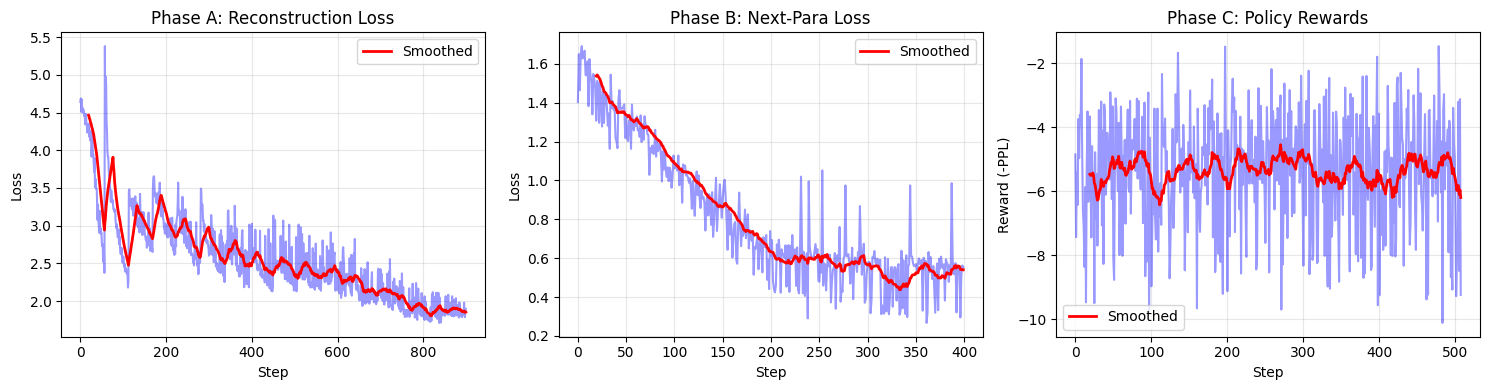

In [17]:
import matplotlib.pyplot as plt

def plot_training_curves(recon_losses, next_losses, policy_rewards, sft_losses=None):
    """Plot training curves for all phases including SFT."""
    # Determine number of subplots
    n_plots = 3 + (1 if sft_losses else 0)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 4))

    # Helper for smoothing
    def plot_with_smooth(ax, data, title, ylabel, color='blue', smooth_color='red'):
        if not data: return
        ax.plot(data, alpha=0.4, color=color)
        window = min(20, len(data) // 5 + 1)
        if window > 1:
            smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
            ax.plot(range(window-1, len(data)), smoothed, '-', linewidth=2, color=smooth_color, label='Smoothed')
        ax.set_title(title)
        ax.set_xlabel('Step')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 1. Reconstruction Loss
    if recon_losses:
        plot_with_smooth(axes[0], recon_losses, 'Phase A: Reconstruction Loss', 'Loss')

    # 2. Next-Para Loss
    if next_losses:
        plot_with_smooth(axes[1], next_losses, 'Phase B: Next-Para Loss', 'Loss')

    # 3. Policy Rewards
    if policy_rewards:
        plot_with_smooth(axes[2], policy_rewards, 'Phase C: Policy Rewards', 'Reward (-PPL)')

    # 4. SFT Loss
    if sft_losses and len(axes) > 3:
        plot_with_smooth(axes[3], sft_losses, 'Phase D: SFT Generation Loss', 'Loss')

    plt.tight_layout()
    plt.show()

# Plot all training curves including SFT
plot_training_curves(recon_losses, next_losses, policy_rewards, sft_losses if 'sft_losses' in globals() else None)

## 14. Generation / Inference

Test the trained REFRAG model on sample questions.

In [18]:
def run_inference(model: REFRAG, question: str, index_dir: str, topk: int = 4,
                  k: int = 32, p: float = 0.25, max_new: int = 128,
                  use_policy: bool = True, verbose: bool = True):
    """
    Run REFRAG inference on a question.
    """
    # Load index
    texts, index = load_index_bundle(index_dir)

    # Encode query and retrieve (use cached encoder to avoid reloading model each call)
    if not hasattr(run_inference, '_qenc') or run_inference._qenc is None:
        run_inference._qenc = PassageEncoder(config.embed_model, device=DEVICE)
    qv = run_inference._qenc.encode_query(question)
    scores, indices = search_index(index, qv, topk)
    passages = [texts[i] for i in indices]

    if verbose:
        print(f"\n{'='*60}")
        print(f"Question: {question}")
        print(f"{'='*60}")
        print(f"\nRetrieved Passages (top-{topk}):")
        for i, (p_text, score) in enumerate(zip(passages, scores)):
            print(f"  [{i+1}] (score: {score:.3f}) {p_text[:100]}...")

    # Generate with REFRAG
    result = model.generate(
        question=question,
        passages=passages,
        k=k,
        p=p,
        max_new_tokens=max_new,
        temperature=0.0,
        use_policy=use_policy
    )

    if verbose:
        print(f"\n{'='*60}")
        print(f"REFRAG Answer: {result['answer']}")
        print(f"{'='*60}")
        print(f"Performance:")
        print(f"  - TTFT: {result['TTFT_sec']:.3f} sec")
        print(f"  - TTIT avg: {result['TTIT_avg_sec']*1000:.2f} ms")
        print(f"  - Throughput: {result['throughput_tok_per_sec']:.1f} tok/s")
        print(f"  - Chunks: {result['meta'].get('num_chunks', 'N/A')}")
        print(f"  - Expanded: {result['meta'].get('num_expanded', 'N/A')}")

    return result

# Test questions
test_questions = [
    "Which river flows through City_1052?",
    "Where is Person_278 affiliated?",
    "What is the melting point of Alloy_925?",
    "What is the primary research institution in City_2124?",
    "What is the primary research institution in City_2548?",
]

# Load trained weights
try:
    # Load encoder and projector from Phase B (or Phase A as fallback)
    for load_dir in [CPT_NEXT_DIR, CPT_RECON_DIR]:
        enc_path = os.path.join(load_dir, "encoder.pt")
        proj_path = os.path.join(load_dir, "projector.pt")
        if os.path.exists(enc_path):
            model.encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))
            print(f"✓ Loaded encoder from {load_dir}")
        if os.path.exists(proj_path):
            model.projector.load_state_dict(torch.load(proj_path, map_location=DEVICE))
            print(f"✓ Loaded projector from {load_dir}")
        if os.path.exists(enc_path):
            break  # Use the latest available checkpoint

    # Load policy if available
    policy_path = os.path.join(POLICY_DIR, "policy.pt")
    if os.path.exists(policy_path):
        model.policy.load_state_dict(torch.load(policy_path, map_location=DEVICE))
        print("✓ Loaded policy weights")

except Exception as e:
    print(f"Note: Could not load weights: {e}")

# Run inference on test questions
print("\n" + "="*60)
print("Running REFRAG Inference")
print("="*60)

results = []
for q in test_questions[:3]:  # Run on first 3 questions
    result = run_inference(
        model=model,
        question=q,
        index_dir=INDEX_DIR,
        topk=config.topk,
        k=config.chunk_len_tokens,
        p=config.selective_p,
        max_new=config.max_out_tokens,
        use_policy=True,
        verbose=True
    )
    results.append(result)
    print()

/tmp/ipython-input-2125485211.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))


✓ Loaded encoder from runs/cpt_next
✓ Loaded projector from runs/cpt_next
✓ Loaded policy weights

Running REFRAG Inference


/tmp/ipython-input-2125485211.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.projector.load_state_dict(torch.load(proj_path, map_location=DEVICE))
/tmp/ipython-i


Question: Which river flows through City_1052?

Retrieved Passages (top-4):
  [1] (score: 0.795) TITLE: Atlas Entry — City_1052. City_1052 is a regional hub in Country_030. It lies on the banks of ...
  [2] (score: 0.739) TITLE: Atlas Entry — City_2512. City_2512 is a regional hub in Country_021. It lies on the banks of ...
  [3] (score: 0.736) TITLE: Atlas Entry — City_2112. City_2112 is a regional hub in Country_116. It lies on the banks of ...
  [4] (score: 0.731) TITLE: Atlas Entry — City_852. City_852 is a regional hub in Country_174. It lies on the banks of Ri...

REFRAG Answer: River_301

Explanation: The correct answer is option C.
Performance:
  - TTFT: 0.029 sec
  - TTIT avg: 26.44 ms
  - Throughput: 37.8 tok/s
  - Chunks: 17
  - Expanded: 4


Question: Where is Person_278 affiliated?

Retrieved Passages (top-4):
  [1] (score: 0.779) TITLE: Biography — Person_278. Person_278 is a researcher in Field_11 affiliated with Institution_08...
  [2] (score: 0.735) TITLE: Biography —

## 15. Compare REFRAG vs Standard RAG

Compare the performance of REFRAG (with compression) vs standard RAG (no compression).

In [19]:
def compare_refrag_vs_rag(model: REFRAG, question: str, index_dir: str, topk: int = 4):
    """
    Compare REFRAG (compressed) vs standard RAG (full context).
    """
    texts, index = load_index_bundle(index_dir)
    # Use cached encoder to avoid reloading model each call
    if not hasattr(compare_refrag_vs_rag, '_qenc') or compare_refrag_vs_rag._qenc is None:
        compare_refrag_vs_rag._qenc = PassageEncoder(config.embed_model, device=DEVICE)
    qv = compare_refrag_vs_rag._qenc.encode_query(question)
    _, indices = search_index(index, qv, topk)
    passages = [texts[i] for i in indices]

    print(f"\nQuestion: {question}")
    print("-" * 50)

    # REFRAG (compressed)
    refrag_result = model.generate(
        question=question,
        passages=passages,
        k=config.chunk_len_tokens,
        p=config.selective_p,
        max_new_tokens=config.max_out_tokens,
        temperature=0.0,
        use_policy=True
    )

    # Standard RAG (no compression, p=1.0)
    rag_result = model.generate(
        question=question,
        passages=passages,
        k=config.chunk_len_tokens,
        p=1.0,  # Full expansion = standard RAG
        max_new_tokens=config.max_out_tokens,
        temperature=0.0,
        use_policy=False
    )

    print(f"\n📦 REFRAG (p={config.selective_p}):")
    print(f"   Answer: {refrag_result['answer']}")
    print(f"   TTFT: {refrag_result['TTFT_sec']:.3f}s | Throughput: {refrag_result['throughput_tok_per_sec']:.1f} tok/s")

    print(f"\n📄 Standard RAG (p=1.0):")
    print(f"   Answer: {rag_result['answer']}")
    print(f"   TTFT: {rag_result['TTFT_sec']:.3f}s | Throughput: {rag_result['throughput_tok_per_sec']:.1f} tok/s")

    # Speedup
    if refrag_result['TTFT_sec'] > 0:
        speedup = rag_result['TTFT_sec'] / refrag_result['TTFT_sec']
        print(f"\n⚡ TTFT Speedup: {speedup:.2f}x")

    return {
        "refrag": refrag_result,
        "rag": rag_result
    }

# Compare on a sample question
print("="*60)
print("REFRAG vs Standard RAG Comparison")
print("="*60)

comparison = compare_refrag_vs_rag(
    model=model,
    question="Which river flows through City_464",
    index_dir=INDEX_DIR,
    topk=config.topk,
)

REFRAG vs Standard RAG Comparison

Question: Which river flows through City_464
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



📦 REFRAG (p=0.25):
   Answer: River_391

Explanation: The coordinates of the cities are given in a table. We can use these to find out which river flows through City_464.

City 1 is located at (0, -2). It lies on the banks of River_166.
City 3 is located between Cities 4 and 5. Since it has no coordinate values listed for itself we know that its location must be somewhere along this line segment connecting them both with equal distance from each other i.e., halfway downriver or upstream towards city number one; therefore since there were only two possible locations left after eliminating all others then either way works fine
   TTFT: 0.030s | Throughput: 37.1 tok/s

📄 Standard RAG (p=1.0):
   Answer: [River_119]

Explanation:

City_464 has been mentioned as being located near or along with one particular river (in this case it's "river" #119). This means that we can eliminate all other rivers from consideration since they are not relevant for answering our query.
The correct option th

## 16. Interactive Inference

In [20]:
# Check if the specific entity exists in the corpus
search_term = "City_464"
found = False
with open("data/corpus_large.txt", "r") as f:
    for i, line in enumerate(f):
        if f" {search_term}." in line or f" {search_term} " in line:
            print(f"Found '{search_term}' on line {i+1}: {line[:100]}...")
            found = True
            break

if not found:
    print(f"'{search_term}' not found in corpus! This explains the retrieval failure.")

Found 'City_464' on line 465: TITLE: Atlas Entry — City_464. City_464 is a regional hub in Country_160. It lies on the banks of Ri...


In [21]:
# Test with a question relevant to the synthetic training data
SYNTHETIC_QUESTION = "Which river flows through City_464?"

print(f"Testing with in-domain question: {SYNTHETIC_QUESTION}")

result_syn = run_inference(
    model=model,
    question=SYNTHETIC_QUESTION,
    index_dir=INDEX_DIR,
    topk=config.topk,
    k=config.chunk_len_tokens,
    p=config.selective_p,
    max_new=32,  # Short answer expected
    use_policy=True,
    verbose=True
)

Testing with in-domain question: Which river flows through City_464?

Question: Which river flows through City_464?

Retrieved Passages (top-4):
  [1] (score: 0.788) TITLE: Atlas Entry — City_464. City_464 is a regional hub in Country_160. It lies on the banks of Ri...
  [2] (score: 0.730) TITLE: Atlas Entry — City_1284. City_1284 is a regional hub in Country_110. It lies on the banks of ...
  [3] (score: 0.725) TITLE: Atlas Entry — City_2664. City_2664 is a regional hub in Country_120. It lies on the banks of ...
  [4] (score: 0.725) TITLE: Atlas Entry — City_2244. City_2244 is a regional hub in Country_075. It lies on the banks of ...

REFRAG Answer: River_391

Explanation: The coordinates of the cities are given in a table. We can use these to find out which river flows through City_464.
Performance:
  - TTFT: 0.029 sec
  - TTIT avg: 27.78 ms
  - Throughput: 37.2 tok/s
  - Chunks: 17
  - Expanded: 4


## 17. Save and Load Models

Save the trained model to Google Drive for persistence, or load a previously trained model.

In [22]:
def mount_drive():
    """Mount Google Drive for persistent storage."""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✓ Google Drive mounted")
        return True
    except ImportError:
        print("Not running in Colab - skipping Drive mount")
        return False

mount_drive()

def save_to_drive(model: REFRAG, drive_path: str = "/content/drive/MyDrive/refrag_models_retrained"):
    """Save all model components to Google Drive."""
    os.makedirs(drive_path, exist_ok=True)

    # Save encoder, projector, policy
    torch.save(model.encoder.state_dict(), os.path.join(drive_path, "encoder.pt"))
    torch.save(model.projector.state_dict(), os.path.join(drive_path, "projector.pt"))
    torch.save(model.policy.state_dict(), os.path.join(drive_path, "policy.pt"))

    # Save full model state
    torch.save(model.state_dict(), os.path.join(drive_path, "refrag_full.pt"))

    # Save config
    import pickle
    with open(os.path.join(drive_path, "config.pkl"), "wb") as f:
        pickle.dump(config, f)

    print(f"✓ Model saved to {drive_path}")

def load_from_drive(model: REFRAG, drive_path: str = "/content/drive/MyDrive/refrag_models_retrained"):
    """Load model components from Google Drive."""
    try:
        full_path = os.path.join(drive_path, "refrag_full.pt")
        if os.path.exists(full_path):
            model.load_state_dict(torch.load(full_path, map_location=DEVICE), strict=False)
            print(f"✓ Loaded full model from {drive_path}")
        else:
            # Load individual components
            enc_path = os.path.join(drive_path, "encoder.pt")
            proj_path = os.path.join(drive_path, "projector.pt")
            pol_path = os.path.join(drive_path, "policy.pt")

            if os.path.exists(enc_path):
                model.encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))
            if os.path.exists(proj_path):
                model.projector.load_state_dict(torch.load(proj_path, map_location=DEVICE))
            if os.path.exists(pol_path):
                model.policy.load_state_dict(torch.load(pol_path, map_location=DEVICE))
            print(f"✓ Loaded model components from {drive_path}")
    except Exception as e:
        print(f"Error loading model: {e}")

save_to_drive(model)
# load_from_drive(model)

Mounted at /content/drive
✓ Google Drive mounted
✓ Model saved to /content/drive/MyDrive/refrag_models_retrained


In [23]:
import gc
import torch

def cleanup_gpu():
    """Free up GPU memory by deleting model and clearing cache."""
    global model

    if 'model' in globals():
        del model
        print("Model deleted from memory.")
    else:
        print("Model not found in memory.")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory cleared. Current usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

cleanup_gpu()

Model deleted from memory.
GPU Memory cleared. Current usage: 0.42 GB


## 18. Summary & Next Steps

### What We've Done
1. ✅ Set up the Colab environment with GPU support
2. ✅ Built a FAISS index for passage retrieval
3. ✅ Trained REFRAG in three phases:
   - **Phase A**: Reconstruction curriculum (encoder + projector)
   - **Phase B**: Next-paragraph prediction (full model)
   - **Phase C**: Policy training (REINFORCE)
4. ✅ Generated answers with REFRAG compression
5. ✅ Compared REFRAG vs standard RAG performance

### Key Hyperparameters to Tune
| Parameter | Description | Default |
|-----------|-------------|---------|
| `chunk_len_tokens` (k) | Tokens per chunk - lower = more compression | 32 |
| `selective_p` | Max expansion fraction | 0.25 |
| `cpt_*_steps` | Training steps per phase | 200 |
| `lr` | Learning rate | 2e-5 |
| `topk` | Number of retrieved passages | 4 |

### Next Steps
- **Scale up training**: Increase training steps for better convergence
- **Use larger decoder**: Try `meta-llama/Llama-3.2-3B` for better quality
- **Add more data**: Train on larger corpus for better retrieval
- **Experiment with k and p**: Find optimal compression/quality trade-off

### Resources
- [REFRAG Paper](https://arxiv.org/abs/...) (Meta Superintelligence Labs)
- [Hugging Face Transformers](https://huggingface.co/docs/transformers)
- [FAISS Documentation](https://faiss.ai/)

**Reasoning**:
The 1,000-step training pipeline across all phases (Reconstruction, Next-Paragraph, Policy, and SFT) has completed successfully, collecting loss and reward data in the corresponding variables. To assess the model's convergence and training stability, I will now visualize these metrics by plotting the training curves using the previously defined `plot_training_curves` function.

